In [1]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def remove_noise(binary_image):
    ret_val = erode(erode(dilate(binary_image)))
    ret_val = invert(ret_val)
    return ret_val


In [2]:
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions = []
    props = []
    sizes = []
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        region = image_bin[y:y+h+1,x:x+w+1];
        props.append((x, w*h, resize_region(region)))
        cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    props = sorted(props)
    
    #print [(y,x) for y,x,w,h,region in props]
    sizes = [size for x,size,region in props]
    regions = [region for x,size,region in props]
    
    return image_orig, regions, sizes

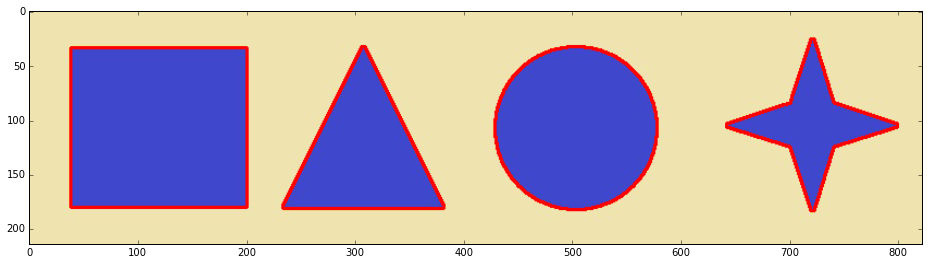

In [18]:
train=load_image('primer1_train.jpg')
display_image(train)
train_bin=image_bin(image_gray(train))
train_bin=invert(train_bin)
display_image(train_bin)
img, contours, hierarchy = cv2.findContours(train_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = train.copy()
cv2.drawContours(img, contours, -1, (255,0,0), 2)
plt.imshow(img)

In [12]:
def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(4, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=2000, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

Broj prepoznatih regiona: 4


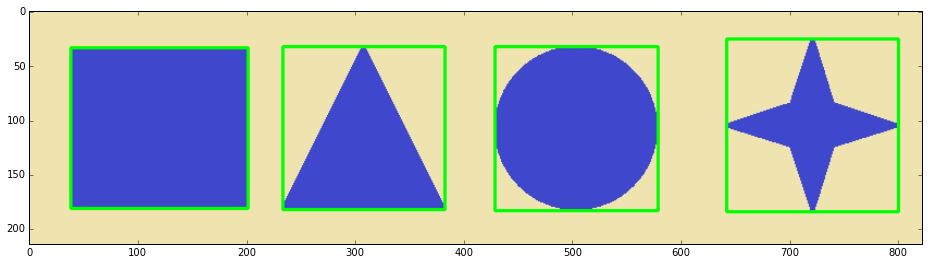

In [29]:
train=load_image('primer1_train.jpg')
#display_image(train)
train_bin=image_bin(image_gray(train))
train_bin=invert(train_bin)
#display_image(train_bin)
selected_regions, shapes, sizes = select_roi(train.copy(), train_bin)
display_image(selected_regions)
print 'Broj prepoznatih regiona:', len(shapes)

In [36]:
alphabet = ['square', 'triangle', 'circle', 'star']
inputs = prepare_for_ann(shapes)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

In [37]:
result = ann.predict(np.array(inputs, np.float32))
print display_result(result, alphabet)

['square', 'triangle', 'circle', 'star']


In [75]:
def display_result(outputs, alphabet,k_means):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    #result = []
    big_elem={}
    small_elem={}
    big_group=max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    for idx, output in enumerate(outputs[0:,:]):
        elem = alphabet[winner(output)]
        if (k_means.labels_[idx] == big_group):
            if elem not in big_elem:
                big_elem[elem]=0
            big_elem[elem]+=1
        else:
            if elem not in small_elem:
                small_elem[elem]=0
            small_elem[elem]+=1
    result = ""
    for key, value in big_elem.iteritems():
        result += str(value) + " big " + str(key) + ("s\n" if (value > 1 and value != 0) else "\n")
    for key, value in small_elem.iteritems():
        result += str(value) + " small " + str(key) + ("s\n" if (value > 1 and value != 0) else "\n")
    return result    
        

KMeans(copy_x=True, init='k-means++', max_iter=2000, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=1e-05,
    verbose=0)

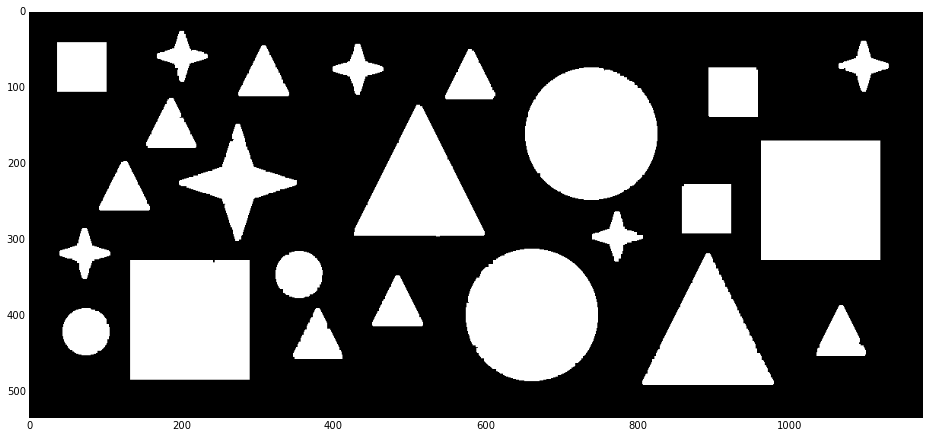

In [72]:
test=load_image('primer1_test.jpg')
test_bin=image_bin(image_gray(test))
test_bin=erode(dilate(test_bin))
test_bin=erode(test_bin)
test_bin=invert(test_bin)
display_image(test_bin)

selected_regions, shapes, sizes = select_roi(test.copy(), test_bin)
sizes = np.array(sizes).reshape(len(sizes), 1)

k_means = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means.fit(sizes)

In [76]:
inputs = prepare_for_ann(shapes)
results = ann.predict(np.array(inputs, np.float32))
print display_result(results, alphabet,k_means)



2 big triangles
2 big circles
2 big squares
1 big star
7 small triangles
2 small circles
3 small squares
5 small stars

